In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'darkgrid', font_scale = 1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

## Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Train.shape: ', train.shape)
print('Test.shape: ', test.shape)
train.head(5)

Train.shape:  (8693, 14)
Test.shape:  (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


##### Missing values

In [3]:
print('Train missing values:')
print(train.isna().sum())
print()
print('Test missing values:')
print(test.isna().sum())

Train missing values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Test missing values:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


##### Duplicates

In [4]:
print(f'Duplicates in train: {train.duplicated().sum()}, ({np.round(100 * train.duplicated().sum() / len(train), 1)}%)')
print(f'Duplicates in test: {test.duplicated().sum()}, ({np.round(100 * test.duplicated().sum() / len(test), 1)}%)')

Duplicates in train: 0, (0.0%)
Duplicates in test: 0, (0.0%)


##### Cardinality of features

In [5]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

##### Data types

In [6]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

## EDA

##### Target Distribution

Text(0.5, 1.0, 'Target Distribution')

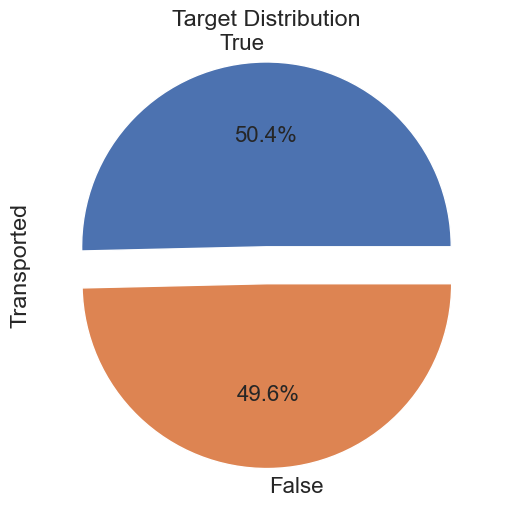

In [7]:
plt.figure(figsize = (6, 6))
# plt.pie(train['Transported'].value_counts(), explode = [0.1, 0.1], labels = ['True', 'False'], autopct = '%.1f%%', shadow = False, textprops = {'fontsize': 16})
# plt.title('Target Distribution')
# plt.legend()
train['Transported'].value_counts().plot.pie(explode = [0.1, 0.1], autopct = '%.1f%%', shadow = False, textprops = {'fontsize': 16}).set_title('Target Distribution')

##### Continuous features

Text(0.5, 0, 'Age(years)')

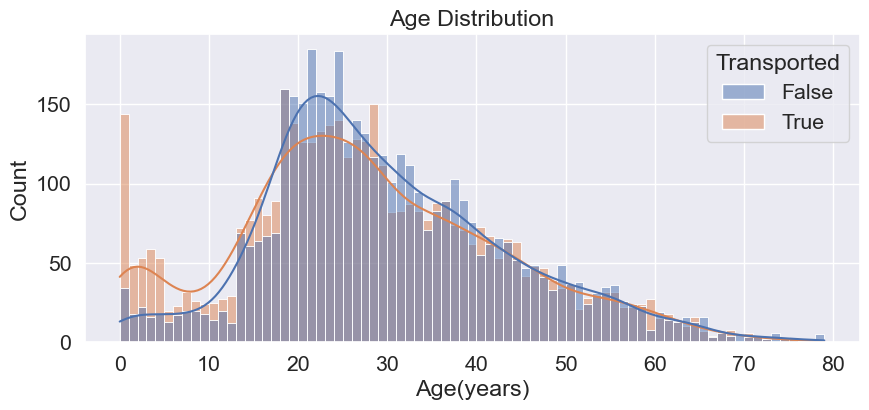

In [8]:
plt.figure(figsize = (10, 4))
sns.histplot(data = train, x = 'Age', hue = 'Transported', binwidth = 1, kde = True)
plt.title('Age Distribution')
plt.xlabel('Age(years)')

*We can see that:*
* 0-18 year olds are more likely to be transported
* 18-25 year olds are more likely not to be transported
* older than 25 year olds are about equally likely to be transported or not

*Insight:*
* Indicate whether a person is a child, adolescent, or adult

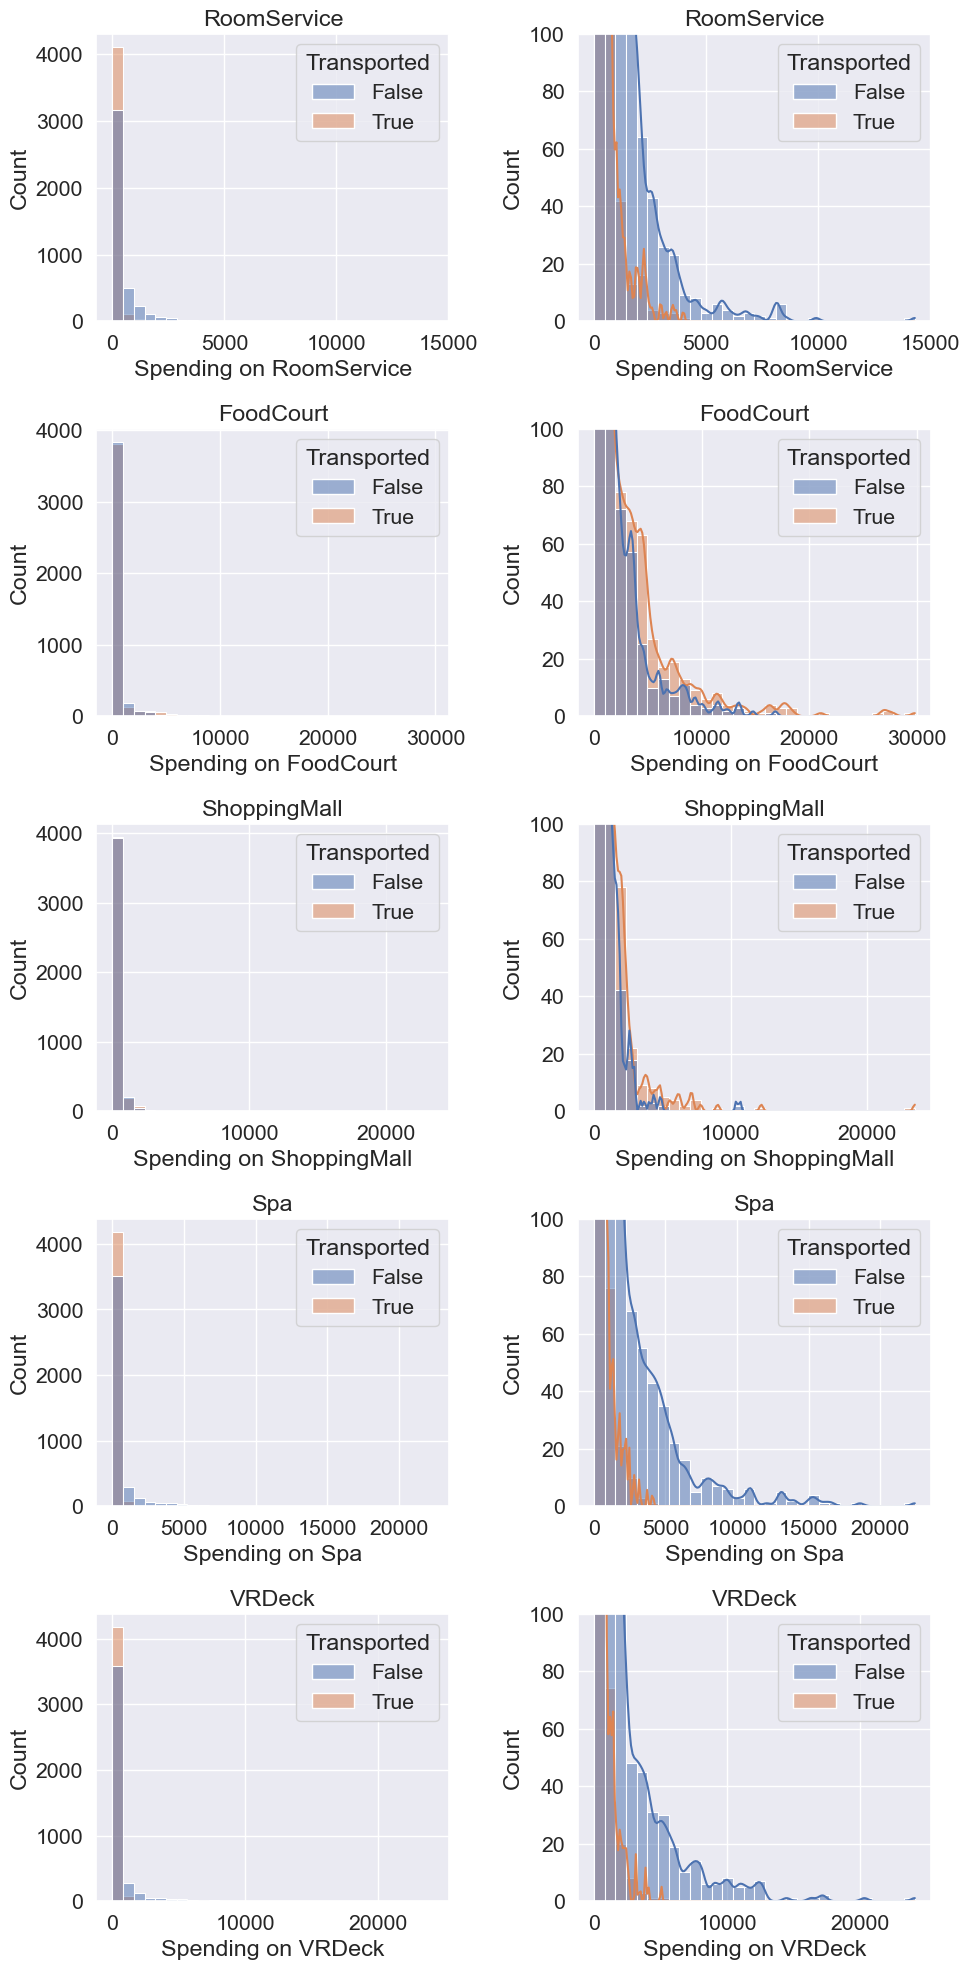

In [9]:
# Expenditure features
exp_fea = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig = plt.figure(figsize = (10, 20))
for i, var in enumerate(exp_fea):
    # left plot
    ax = fig.add_subplot(5, 2, 2 * i + 1)
    sns.histplot(data = train, x = var, axes = ax, bins = 30, kde = False, hue = 'Transported')
    # plt.ylim([0, 100])
    ax.set_xlabel('Spending on ' + var)
    ax.set_title(var)

    # right plot
    ax = fig.add_subplot(5, 2, 2 * i + 2)
    sns.histplot(data = train, x = var, axes = ax, bins = 30, kde = True, hue = 'Transported')
    plt.ylim([0, 100])
    ax.set_xlabel('Spending on ' + var)
    ax.set_title(var)
fig.tight_layout()
plt.show()

*What we have from the plots:*
* Most people do not spend any money
* The distribution of spending decays exponentially.
* A small number of outliers exist.
* People who transport tend to spend less
* RoomService, Spa, and VRDeck have different distributions to FoodCourt and ShoppingMall: we can think of this as luxury vs essential amenities.

*Insight:*
* Create new feature that tracks the total expenditure across all 5 amenities.
* Create a binary feature to indicate if the person has not spent anything.
* Take the log transform to reduce skew.

##### Categorical features

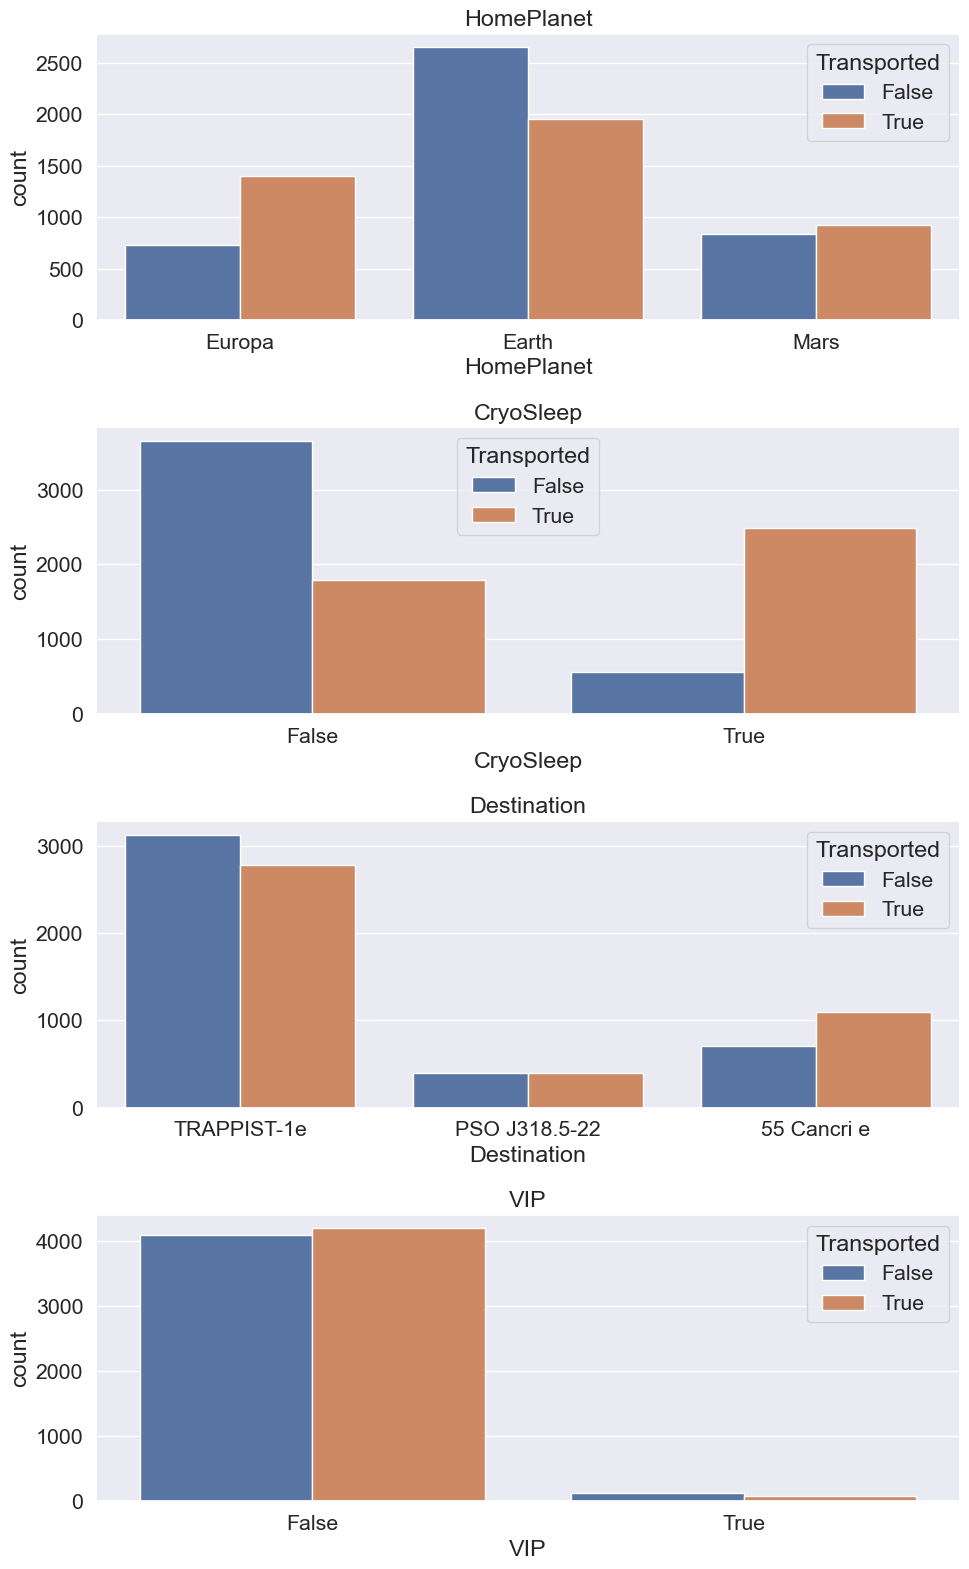

In [10]:
cat_fea = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig = plt.figure(figsize = (10, 16))
for i, var in enumerate(cat_fea):
    ax = fig.add_subplot(4, 1, i + 1)
    sns.countplot(data = train, x = var, axes = ax, hue = 'Transported')
    ax.set_title(var)
fig.tight_layout()
plt.show()

*What we can find:*
* CryoSleep appears to be useful for people who transport
* VIP is not a useful feature that target split by VIP is more or less equal.

*Insight:*
* May drop VIP to prevent overfitting

##### Qualitative features

In [11]:
# Cannot be plotted
qual_fea = ['PassengerId', 'Cabin', 'Name']
train[qual_fea].head(5)

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


*Note:*
* PassengerId takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
* Cabin takes the form deck/num/side, where side can be either P for Port or S for Starboard.

*Insight:*
* May extract group and group size from PassengerId
* May extract the deck, num, and side from Cabin
* Identify families from the lastnames

## Feature engineering

Bin age features into groups. This will be helpful for filling missing values like expenditure according to age.

Text(0.5, 1.0, 'Age group distribution')

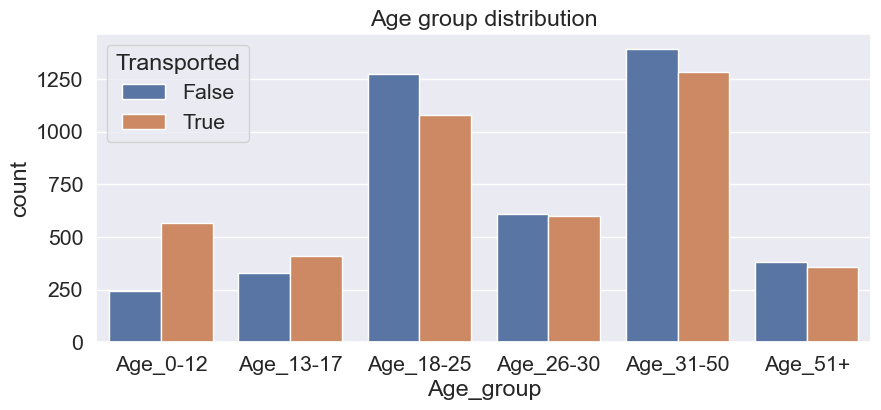

In [12]:
train['Age_group'] = np.nan
train.loc[train['Age'] <= 12, 'Age_group'] = 'Age_0-12'
train.loc[(train['Age'] > 12) & (train['Age'] < 18), 'Age_group'] = 'Age_13-17'
train.loc[(train['Age'] >= 18) & (train['Age'] <= 25), 'Age_group'] = 'Age_18-25'
train.loc[(train['Age'] > 25) & (train['Age'] <= 30), 'Age_group'] = 'Age_26-30'
train.loc[(train['Age'] > 30) & (train['Age'] <= 50), 'Age_group'] = 'Age_31-50'
train.loc[train['Age'] > 50, 'Age_group'] = 'Age_51+'

test['Age_group'] = np.nan
test.loc[test['Age'] <= 12, 'Age_group'] = 'Age_0-12'
test.loc[(test['Age'] > 12) & (test['Age'] < 18), 'Age_group'] = 'Age_13-17'
test.loc[(test['Age'] >= 18) & (test['Age'] <= 25), 'Age_group'] = 'Age_18-25'
test.loc[(test['Age'] > 25) & (test['Age'] <= 30), 'Age_group'] = 'Age_26-30'
test.loc[(test['Age'] > 30) & (test['Age'] <= 50), 'Age_group'] = 'Age_31-50'
test.loc[test['Age'] > 50, 'Age_group'] = 'Age_51+'

plt.figure(figsize = (10, 4))
g = sns.countplot(data = train, x = 'Age_group', hue = 'Transported', order = ['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

##### Expenditure

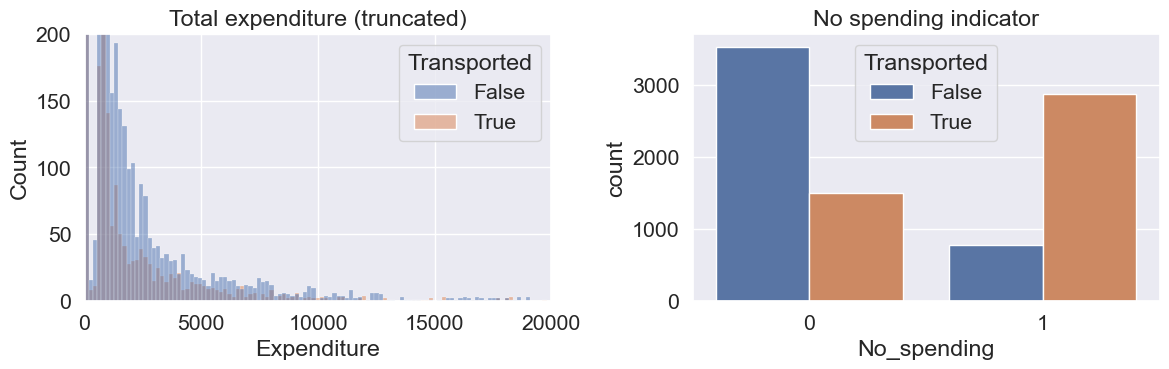

In [13]:
train['Expenditure'] = train[exp_fea].sum(axis = 1)
train['No_spending'] = (train['Expenditure'] == 0).astype(int)
test['Expenditure'] = test[exp_fea].sum(axis = 1)
test['No_spending'] = (test['Expenditure'] == 0).astype(int)

fig = plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data = train, x = 'Expenditure', hue = 'Transported', bins = 200)
plt.title('Total expenditure (truncated)')
plt.xlim([0, 20000])
plt.ylim([0, 200])

plt.subplot(1, 2, 2)
sns.countplot(data = train, x = 'No_spending', hue = 'Transported')
plt.title('No spending indicator')
fig.tight_layout()

##### Passenger group

Extract passenger group and group size form PassengerId

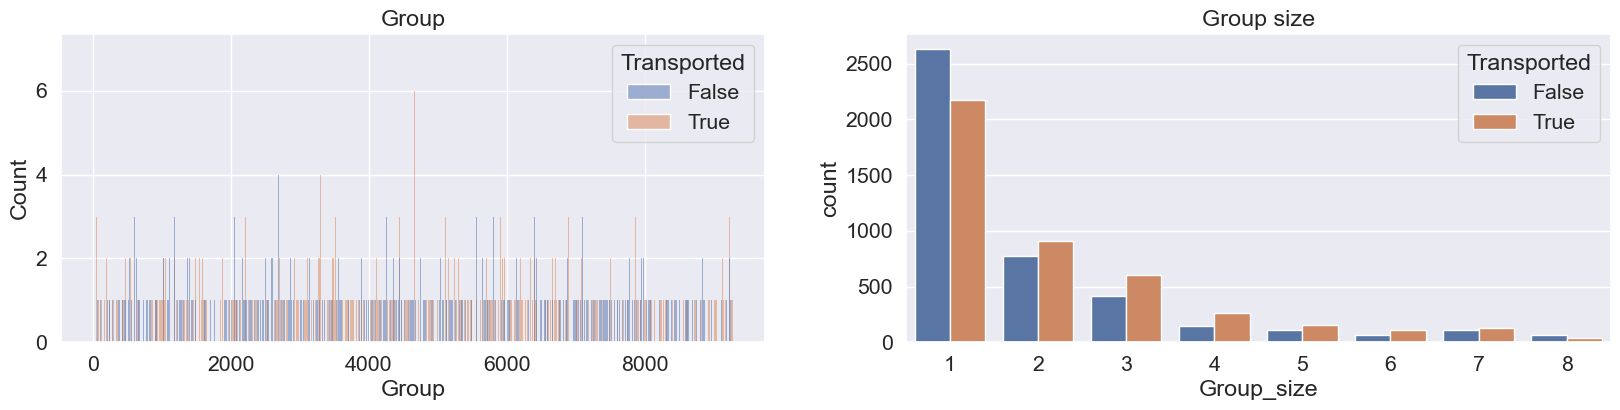

In [14]:
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

train['Group_size'] = train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size'] = test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

plt.figure(figsize = (20, 4))
plt.subplot(1, 2, 1)
sns.histplot(data = train, x = 'Group', hue = 'Transported', binwidth = 1)
plt.title('Group')
fig.tight_layout()

plt.subplot(1, 2, 2)
sns.countplot(data = train, x = 'Group_size', hue = 'Transported')
plt.title('Group size')
fig.tight_layout()

The Group size on the other hand should be a useful feature. In fact, we can compress the feature further by creating a 'Solo' column that tracks whether someone is travelling on their own or not. The figure on the right shows that group size=1 is less likely to be transported than group size>1.

(0.0, 3000.0)

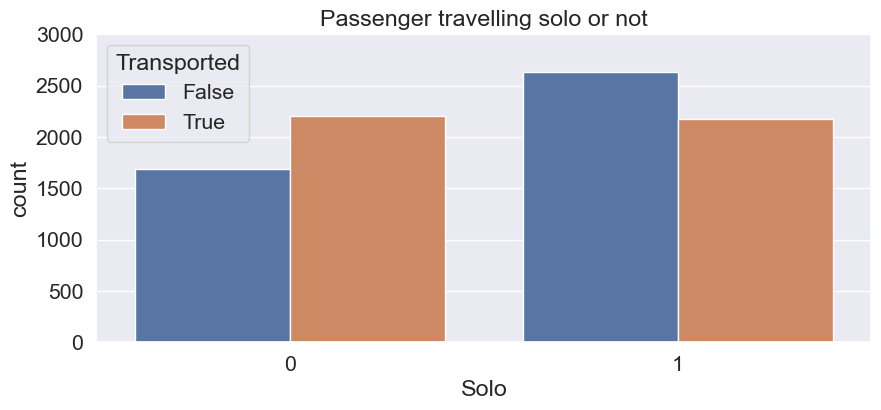

In [15]:
train['Solo'] = (train['Group_size'] == 1).astype(int)
test['Solo'] = (test['Group_size'] == 1).astype(int)

plt.figure(figsize = (10, 4))
sns.countplot(data = train, x = 'Solo', hue = 'Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0, 3000])

##### Cabin

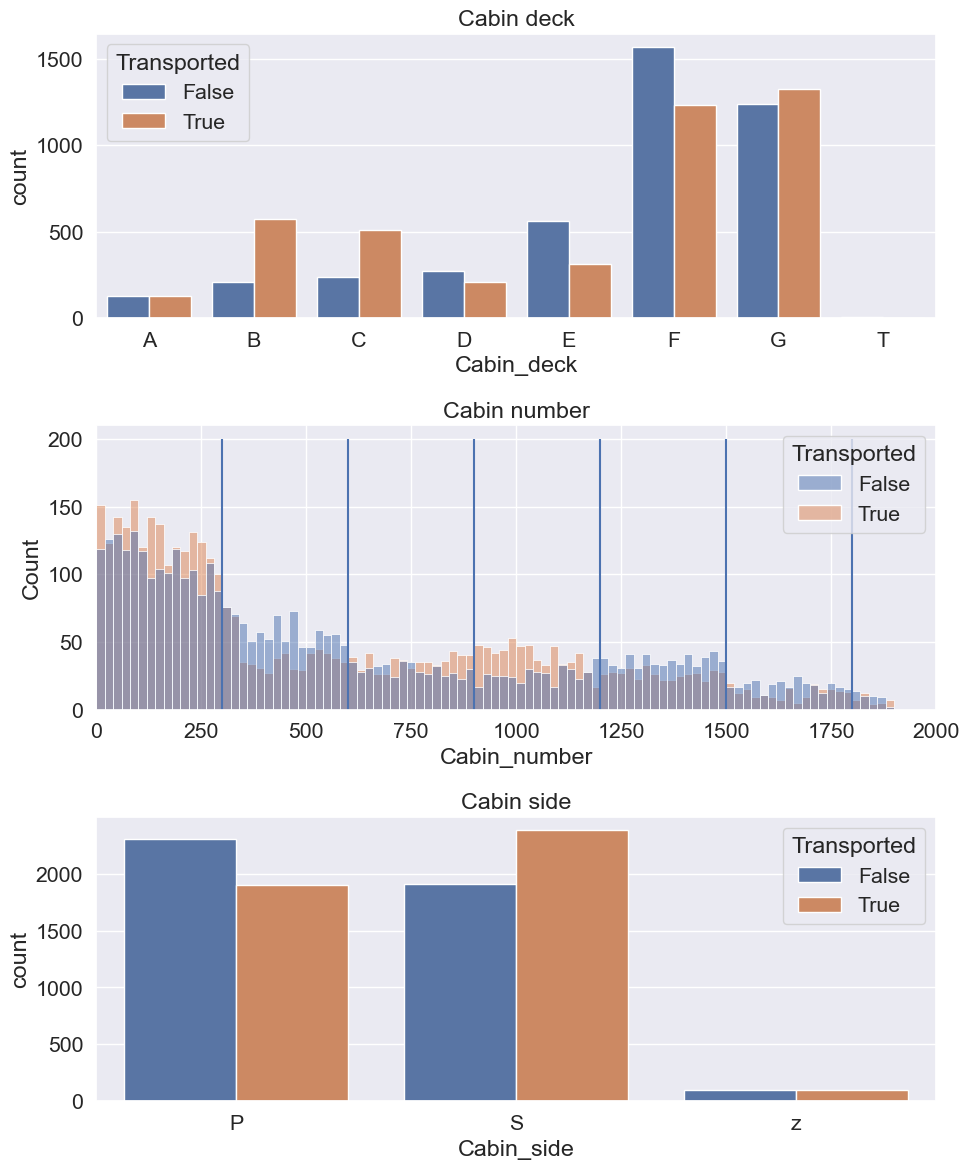

In [16]:
# Fill the nan so we can split the feature
train['Cabin'].fillna('Z/9999/z', inplace = True)
test['Cabin'].fillna('Z/9999/Z', inplace = True)

train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Put nan(s) back
train.loc[train['Cabin_deck'] == 'Z', 'Cabin_deck'] = np.nan
train.loc[train['Cabin_number'] == 9999, 'Cabin_number'] = np.nan
train.loc[train['Cabin_side'] == 'Z', 'Cabin_side'] = np.nan
test.loc[test['Cabin_deck'] == 'Z', 'Cabin_deck'] = np.nan
test.loc[test['Cabin_number'] == 9999, 'Cabin_number'] = np.nan
test.loc[test['Cabin_side'] == 'Z', 'Cabin_side'] = np.nan

train.drop('Cabin', axis = 1, inplace = True)
test.drop('Cabin', axis = 1, inplace = True)

fig = plt.figure(figsize = (10, 12))
plt.subplot(3, 1, 1)
sns.countplot(data = train, x = 'Cabin_deck', hue = 'Transported', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
plt.title('Cabin deck')

plt.subplot(3, 1, 2)
sns.histplot(data = train, x = 'Cabin_number', hue = 'Transported', binwidth = 20)
plt.vlines([300, 600, 900, 1200, 1500, 1800], ymin = 0, ymax = 200, colors = 'b')
plt.title('Cabin number')
plt.xlim([0, 2000])

plt.subplot(3, 1, 3)
sns.countplot(data = train, x = 'Cabin_side', hue = 'Transported')
plt.title('Cabin side')

fig.tight_layout()

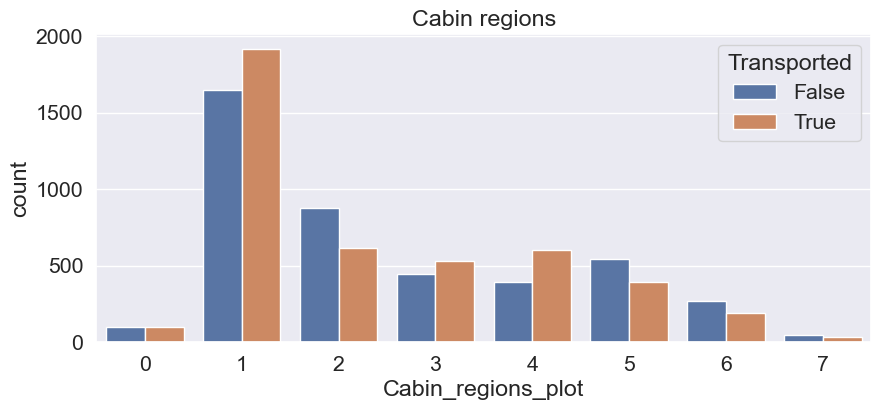

In [17]:
# New feature
train['Cabin_region1'] = (train['Cabin_number'] < 300).astype(int)
train['Cabin_region2'] = ((train['Cabin_number'] >= 300) & (train['Cabin_number'] < 600)).astype(int)
train['Cabin_region3'] = ((train['Cabin_number'] >= 600) & (train['Cabin_number'] < 900)).astype(int)
train['Cabin_region4'] = ((train['Cabin_number'] >= 900) & (train['Cabin_number'] < 1200)).astype(int)
train['Cabin_region5'] = ((train['Cabin_number'] >= 1200) & (train['Cabin_number'] < 1500)).astype(int)
train['Cabin_region6'] = ((train['Cabin_number'] >= 1500) & (train['Cabin_number'] < 1800)).astype(int)
train['Cabin_region7'] = (train['Cabin_number'] >= 1800).astype(int)

test['Cabin_region1'] = (test['Cabin_number'] < 300).astype(int)
test['Cabin_region2'] = ((test['Cabin_number'] >= 300) & (test['Cabin_number'] < 600)).astype(int)
test['Cabin_region3'] = ((test['Cabin_number'] >= 600) & (test['Cabin_number'] < 900)).astype(int)
test['Cabin_region4'] = ((test['Cabin_number'] >= 900) & (test['Cabin_number'] < 1200)).astype(int)
test['Cabin_region5'] = ((test['Cabin_number'] >= 1200) & (test['Cabin_number'] < 1500)).astype(int)
test['Cabin_region6'] = ((test['Cabin_number'] >= 1500) & (test['Cabin_number'] < 1800)).astype(int)
test['Cabin_region7'] = (test['Cabin_number'] >= 1800).astype(int)

plt.figure(figsize = (10, 4))
train['Cabin_regions_plot'] = (train['Cabin_region1'] + 2 * train['Cabin_region2'] + 3 * train['Cabin_region3'] + 4 * train['Cabin_region4'] + 5 * train['Cabin_region5'] + 6 * train['Cabin_region6'] + 7 * train['Cabin_region7'])
sns.countplot(data = train, x = 'Cabin_regions_plot', hue = 'Transported')
plt.title('Cabin regions')

train.drop('Cabin_regions_plot', axis = 1, inplace = True)

##### Lastname

Calculate family size from last name

Text(0.5, 1.0, 'Family size')

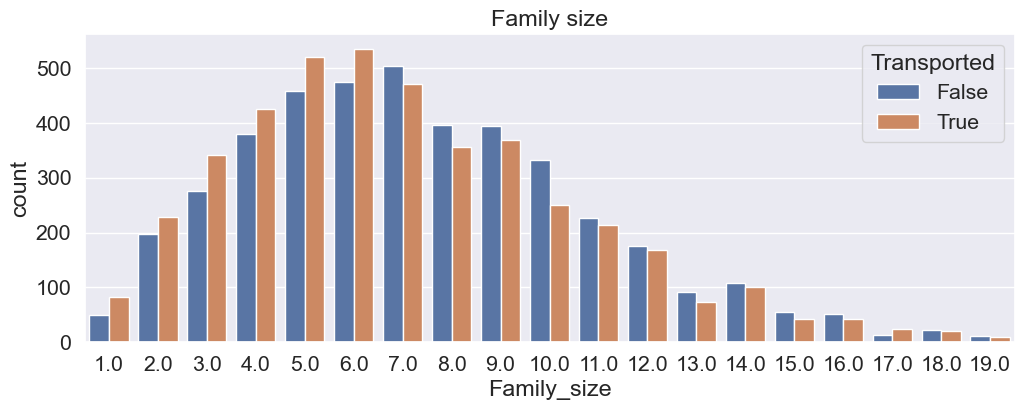

In [18]:
# Fill the nan(s)
train['Name'].fillna('Unknown, Unknown', inplace = True)
test['Name'].fillna('Unknown Unknown', inplace = True)

train['Lastname'] = train['Name'].str.split().str[-1]
test['Lastname'] = test['Name'].str.split().str[-1]

train['Family_size'] = train['Lastname'].map(lambda x: pd.concat([train['Lastname'], test['Lastname']]).value_counts()[x])
test['Family_size'] = test['Lastname'].map(lambda x: pd.concat([train['Lastname'], test['Lastname']]).value_counts()[x])

# Put the nan(s) back in
train.loc[train['Lastname'] == 'Unknown', 'Lastname'] = np.nan
train.loc[train['Family_size'] > 100, 'Family_size'] = np.nan
test.loc[test['Lastname'] == 'Unknown', 'Lastname'] = np.nan
test.loc[test['Family_size'] > 100, 'Family_size'] = np.nan

train.drop('Name', axis = 1, inplace = True)
test.drop('Name', axis = 1, inplace = True)

plt.figure(figsize = (12, 4))
sns.countplot(data = train, x = 'Family_size', hue = 'Transported')
plt.title('Family size')

## Missing values

##### Combine train and test set

Easier to fill out the missing values

In [25]:
y = train['Transported'].copy().astype(int)
x = train.drop('Transported', axis = 1).copy()

data = pd.concat([x, test], axis = 0).reset_index(drop = True)

##### Explore missing values

In [27]:
na_cols = data.columns[data.isna().any()].tolist()
data[na_cols].isna().sum()
mv = pd.DataFrame(data[na_cols].isna().sum(), columns = ['Number_missing'])
mv['Percentage_missing'] = np.round(100 * mv['Number_missing'] / len(data), 2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


Text(0.5, 1.0, 'Heatmap of missing values')

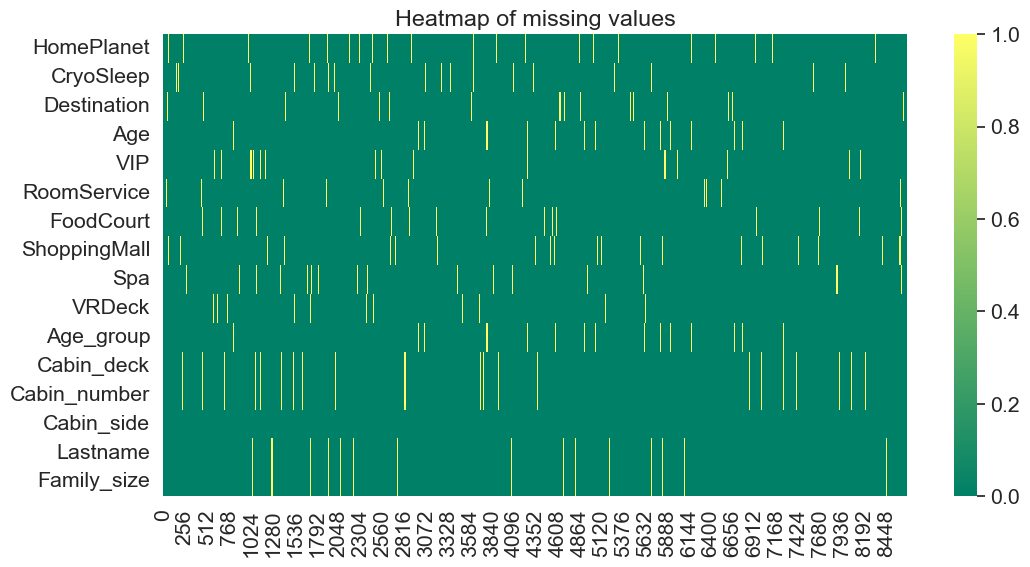

In [28]:
# Heatmap
plt.figure(figsize = (12, 6))
sns.heatmap(data = train[na_cols].isna().T, cmap = 'summer')
plt.title('Heatmap of missing values')

Missing values make up about 2% of the data, which is a relatively small amount. For the most part, they don't seem to be happening at the same time (except the features made from splitting Cabin and Name), but let's inspect closer.

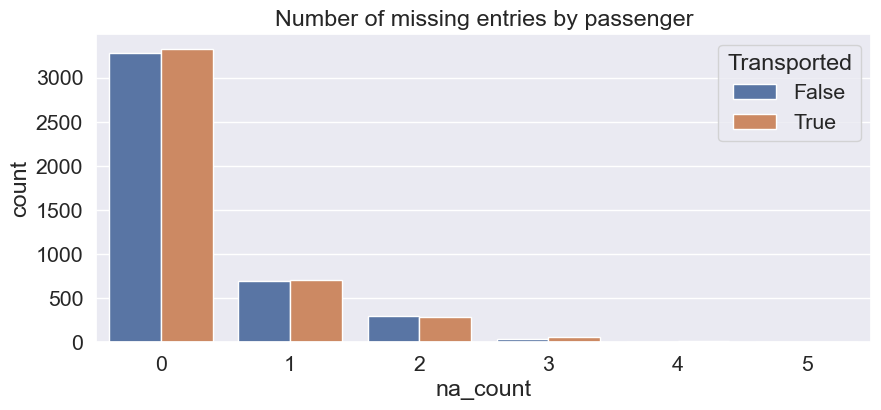

In [29]:
# Countplot of number of missing values by passenger
train['na_count'] = train.isna().sum(axis = 1)
plt.figure(figsize = (10, 4))
sns.countplot(data = train, x = 'na_count', hue = 'Transported')
plt.title('Number of missing entries by passenger')
train.drop('na_count', axis = 1, inplace = True)

*Note:*
* Missing values are independent of the target and for the most part are isolated.
* Even though only 2% of data is missing, about 25% of all passengers have at least 1 missing value.
* PassengerId is the only (original) feature to not have any missing values.

*Insight:*
* Since most of the missing values are isolated it makes sense to try to fill these in as opposed to just dropping rows.
* Is there is a relationship between PassengerId and other features we can fill missing values according to this column.

##### Strategy

The easiest way to deal with missing values is to just use the **median** for continuous features and the **mode** for categorical features. This will work well enough.
If we want to maximise the accuracy of our models then we need to look for patterns within the missing data.
The way to do this is by looking at the **joint distribution** of features, e.g. do passengers from the same group tend to come from the same family.
There are obviously many combinations, so we will just summarise the useful trends I and others have found

##### HomePLanet and Group

In [30]:
# Joint distribution of Group and HomePlanet
GHP_gb = data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


Text(0.5, 1.0, 'Number of unique home planets per group')

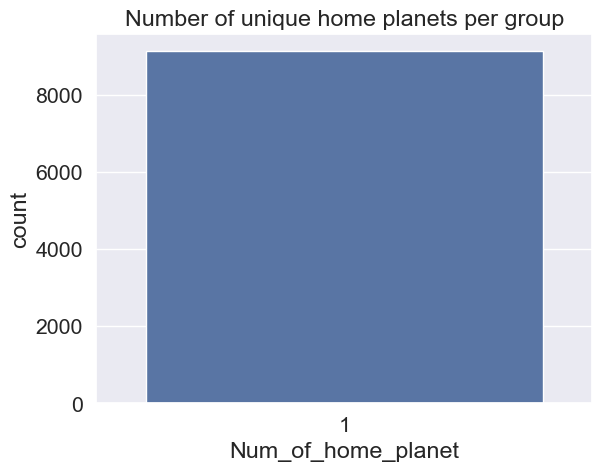

In [53]:
# Countplot of unique values
# pd.DataFrame((GHP_gb > 0).sum(axis = 1))
sns.countplot(pd.DataFrame((GHP_gb > 0).sum(axis = 1), columns = ['Num_of_home_planet']), x = 'Num_of_home_planet')
plt.title('Number of unique home planets per group')